In [1]:
import pandas as pd
from datetime import datetime
import yfinance
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries


def get_historical(quote):
    end = datetime.now()
    start = datetime(end.year - 2, end.month, end.day)
    data = yfinance.download(quote, start=start, end=end)
    df = pd.DataFrame(data=data)
    file_name=quote+".csv"
    df.to_csv(file_name)
    if df.empty:
        ts = TimeSeries(key="dj0yJmk9WVJxNlRuYlZ3TXVjJmQ9WVdrOU1HSTNaMDVFZUZrbWNHbzlNQT09JnM9Y29uc3VtZXJzZWNyZXQmc3Y9MCZ4PWQ1", output_format="pandas")
        data= ts.get_daily_adjusted(symbol="NSE:" + quote, outputsize="full")
        data = data.head(503).iloc[::-1]
        data = data.reset_index()
        df = pd.DataFrame()
        df["Date"] = data["date"]
        df["Open"] = data["1. open"]
        df["High"] = data["2. high"]
        df["Low"] = data["3. low"]
        df["Close"] = data["4. close"]
        df["Adj Close"] = data["5. adjusted close"]
        df["Volume"] = data["6. volume"]
        file_name = quote + ".csv"
        df.to_csv(file_name, index=False)
    return file_name

NVDA
[*********************100%%**********************]  1 of 1 completed


C:\Users\ZUBAIR\AppData\Local\Temp\ipykernel_1912\3515439204.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv(file, sep=',', parse_dates=['Date'], index_col='Date', date_parser=dateparse)


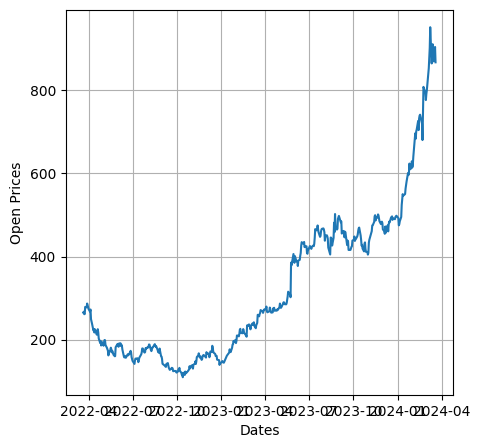

In [2]:
nm = input()
print(nm)
file = get_historical(nm)
# df=pd.read_csv(file)
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
data = pd.read_csv(file, sep=',', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
plt.figure(figsize=(5,5))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'])

In [3]:
data.describe()


,Open,High,Low,Close,Adj Close,Volume
count,502.000000,502.000000,502.000000,502.000000,502.000000,5.020000e+02
mean,323.634820,329.729760,317.659003,324.139502,324.030658,5.099835e+07
std,183.323225,186.296624,179.995793,183.491084,183.530368,1.539563e+07
min,109.709999,117.349998,108.129997,112.269997,112.186234,1.679340e+07
25%,169.915001,174.192505,166.385006,169.942497,169.788754,4.028625e+07
50%,267.785004,271.750000,263.419998,267.459991,267.249481,4.813010e+07
75%,450.435005,459.139992,444.672508,454.432495,454.333794,5.826348e+07
max,951.380005,974.000000,896.020020,926.690002,926.690002,1.543911e+08


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


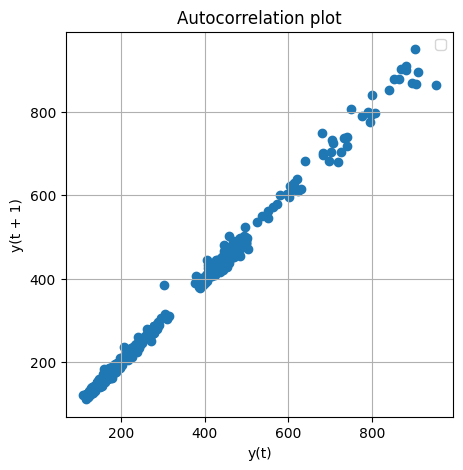

In [4]:
import pandas as pd
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(data['Open'], lag=1)
plt.title('Autocorrelation plot')
plt.grid(True)
plt.legend()


values = pd.DataFrame(data['Open'].values)
dataframe = pd.concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
# print(result)

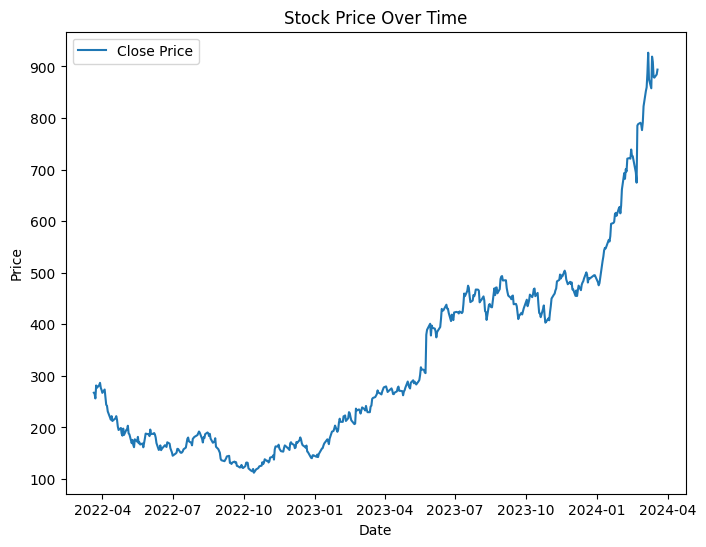

In [5]:
plt.figure(figsize=(8,6))
plt.plot(data['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Over Time')
plt.legend()
plt.show()

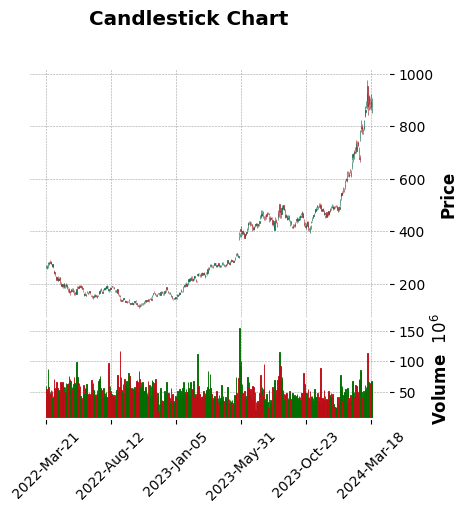

In [6]:
import mplfinance as mpf
mpf.plot(data, type='candle',
        style='charles',
        title='Candlestick Chart',
        volume=True, figsize=(5,5)
        )

In [7]:
#splitting the data into 70% training and 30% testing
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
# plt.figure(figsize=(5,5))
# plt.grid(True)
# plt.xlabel('Dates')
# plt.ylabel('Open Prices')
# plt.plot(data['Open'], 'green', label='Train data')
# plt.plot(test_data['Open'], 'blue', label='Test data')
# plt.legend()

In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# preprocessing training data
train = train_data.iloc[:, 0:1].values 
scaler = MinMaxScaler() 
train_scaled = scaler.fit_transform(train)
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) 
    y_train.append(train_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #Reshaping
# from numpy.random import seed 
# seed(2019)

In [9]:
#preprocessing testing data
test = test_data.iloc[:, 0:1].values 
scaler = MinMaxScaler() 
test_scaled = scaler.fit_transform(test)
timesteps = 7
X_test = []
y_test = []
for i in range(timesteps, test.shape[0]):
    X_test.append(test_scaled[i-timesteps:i, 0]) 
    y_test.append(test_scaled[i, 0]) 
X_test, y_test = np.array(X_test), np.array(y_test)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Bidirectional


model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.20))

model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.25))

model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=50)))
model.add(Dropout(0.25))

model.add(Dense(units=1))

In [11]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 40, batch_size = 32)


Epoch 1/40

14/14 [==============================] - 40s 45ms/step - loss: 0.1015
Epoch 2/40
14/14 [==============================] - 1s 47ms/step - loss: 0.0223
Epoch 3/40
14/14 [==============================] - 1s 37ms/step - loss: 0.0064
Epoch 4/40
14/14 [==============================] - 1s 39ms/step - loss: 0.0057
Epoch 5/40
14/14 [==============================] - 1s 43ms/step - loss: 0.0039
Epoch 6/40
14/14 [==============================] - 1s 43ms/step - loss: 0.0044
Epoch 7/40
14/14 [==============================] - 1s 50ms/step - loss: 0.0041
Epoch 8/40
14/14 [==============================] - 1s 36ms/step - loss: 0.0033
Epoch 9/40
14/14 [==============================] - 0s 35ms/step - loss: 0.0039
Epoch 10/40
14/14 [==============================] - 0s 28ms/step - loss: 0.0033
Epoch 11/40
14/14 [==============================] - 0s 28ms/step - loss: 0.0035
Epoch 12/40
14/14 [==============================] - 0s 31ms/step - loss: 0.0037
Epoch 13/40
14/14 [===============

2/2 [==============================] - 6s 10ms/step
predicted stock price for tomorrow:  [903.8833]


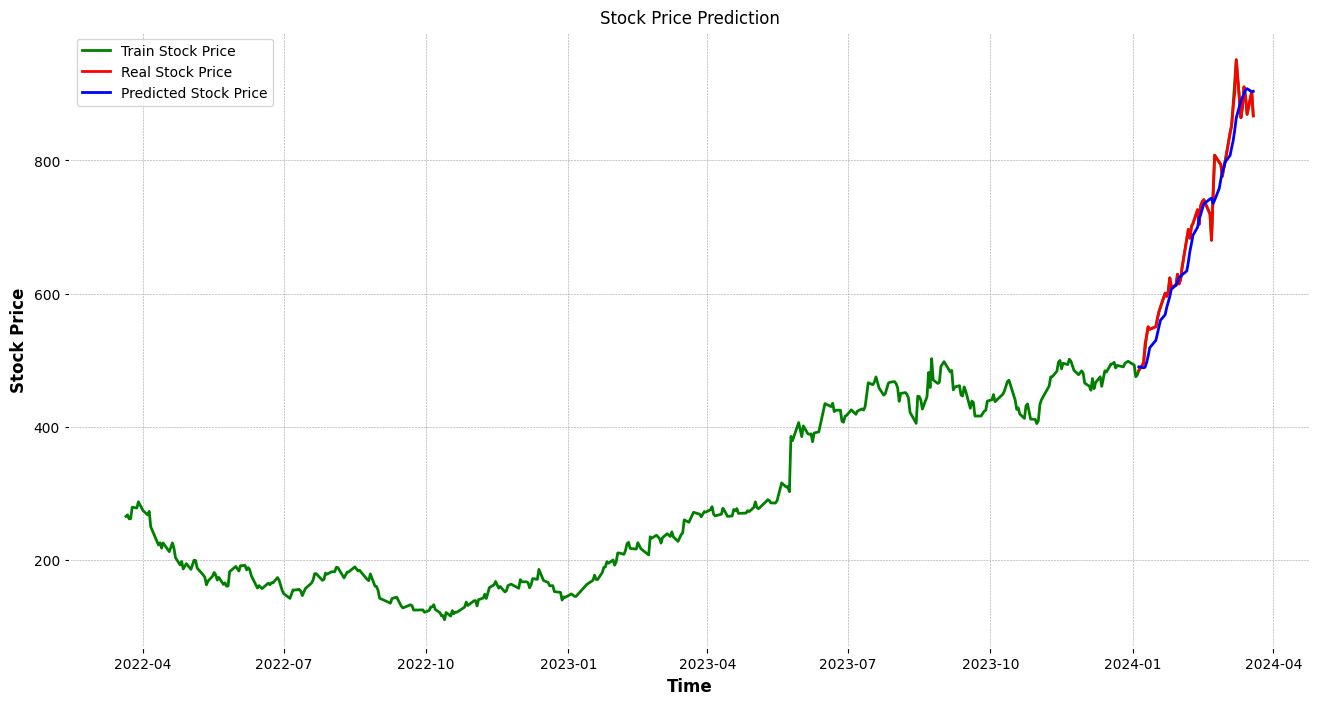

In [12]:
real_stock_price = test_data.iloc[:,0:1].values
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)

test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)

predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
print("predicted stock price for tomorrow: ",predicted_stock_price[len(predicted_stock_price)-1])

plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,mean_absolute_percentage_error

mse14 = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse14))
# mae14 = mean_absolute_error(real_stock_price, predicted_stock_price)
# print('MAE: '+str(mae14))
# rmse14 = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
# print('RMSE: '+str(rmse14))
r214 = mean_absolute_percentage_error(real_stock_price, predicted_stock_price)
print('MAPE Score: ' + str(r214))

MSE: 948.2974718651163
MAPE Score: 0.03446550078674856
